# Import model and create animations

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from architectures import COTGAN
import neptune.new as neptune
from utils import restore_weights

"""
405 - decent
401 - mode collapse
400 - decent
399 - epochs: 300
"""

model_id = "COT-427"

run = neptune.init_run(
                with_id=model_id, # "TIMEGAN-84"
                project="kohmann/COTGAN",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",)
params = run["parameters"].fetch()
params["device"] = "cpu"

model = COTGAN(params)
model = restore_weights(model, run)

https://app.neptune.ai/kohmann/COTGAN/e/COT-427
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/COTGAN/e/COT-427


In [37]:
# Generate samples
n_samples = 9*5
fake = model.generate(n_samples)
fake.shape

torch.Size([45, 30, 120])

In [38]:
batch_nr = 1

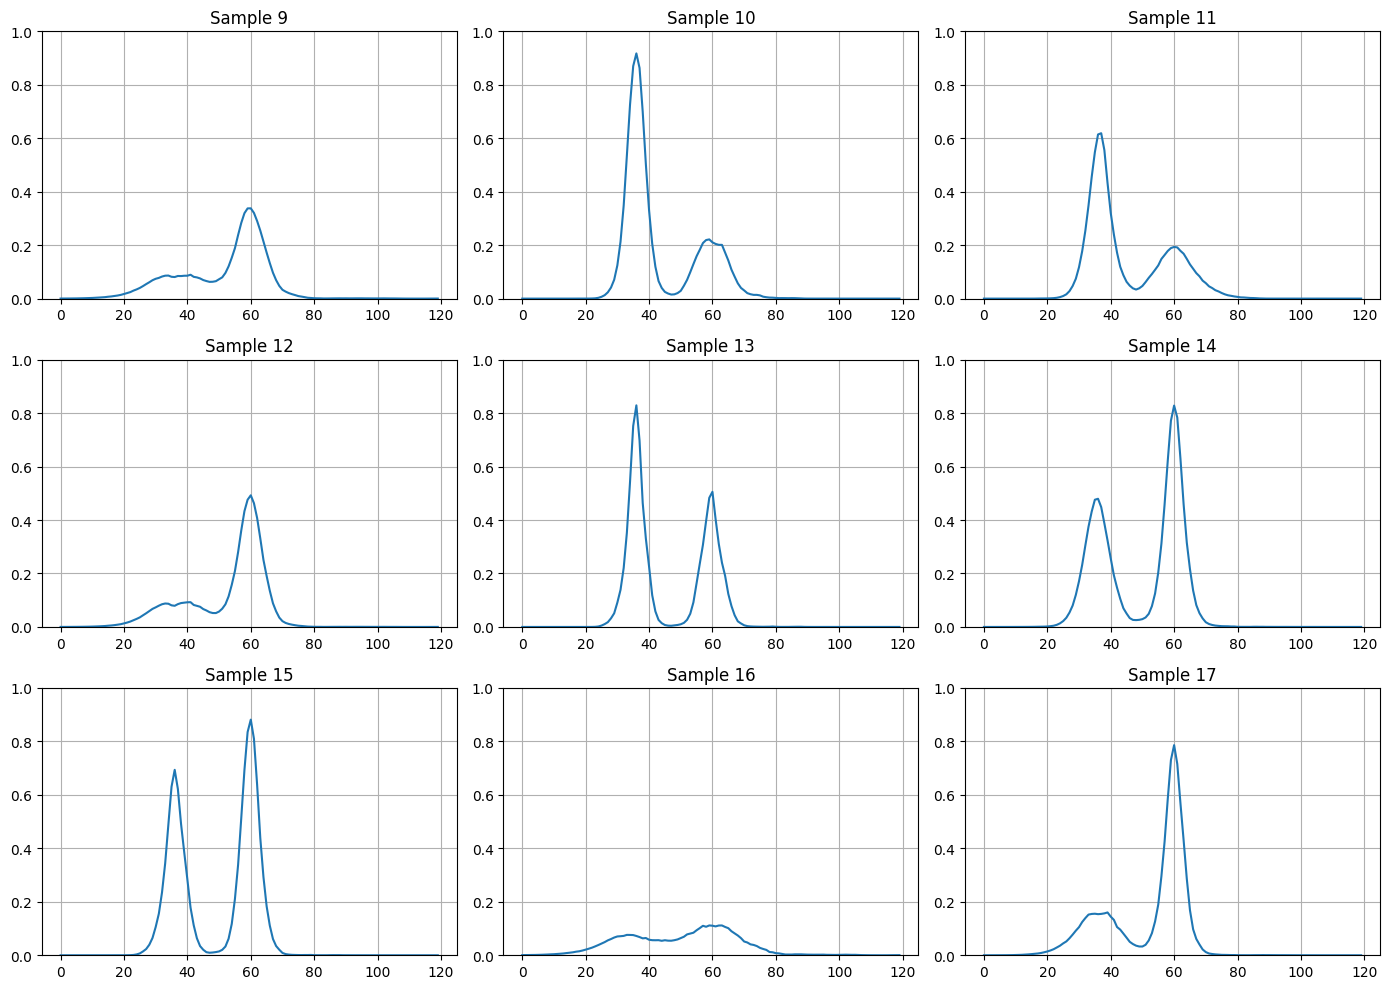

In [39]:
def plot_batch(data, batch_nr):
    start_idx = batch_nr*9
    fig, axs = plt.subplots(3, 3, figsize=(14, 10))
    for ax in axs.flat:
        ax.set_ylim((0, 1))
        ax.grid()
    for i in range(3):
        for j in range(3):
            idx = start_idx + i*3+j
            axs[i, j].plot(data[idx, 0].T)
            axs[i, j].set_title(f"Sample {idx}")

            fig.tight_layout()
plot_batch(fake, batch_nr=batch_nr)

MovieWriter ffmpeg unavailable; using Pillow instead.


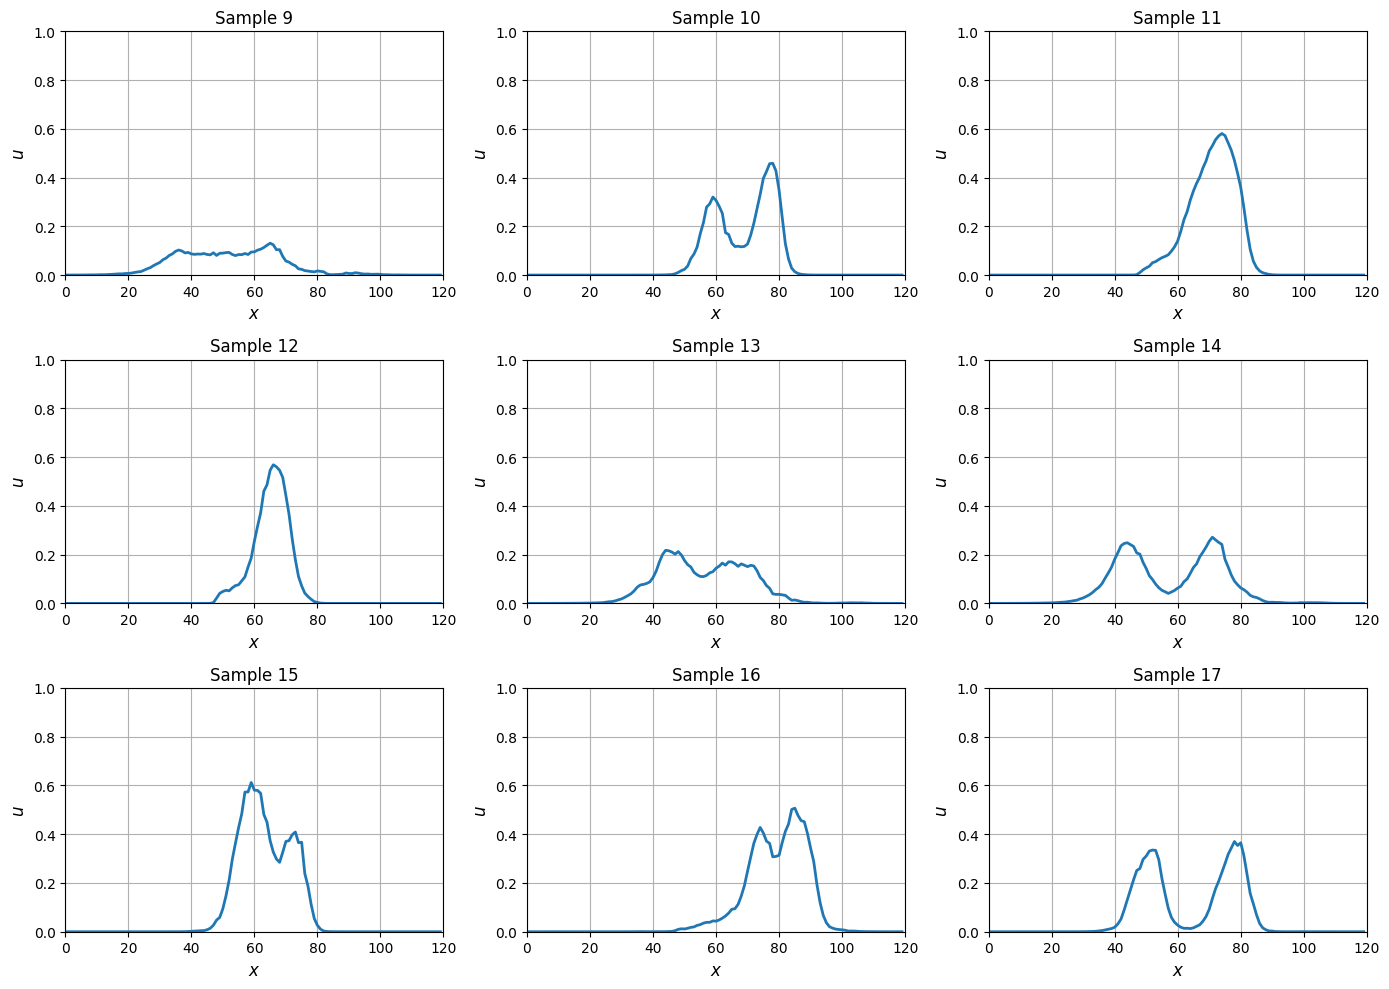

In [32]:
def animate_batch(data, batch_nr, title="soliton_batch"):
    batch_idx = batch_nr * 9
    rc('animation', html='jshtml')
    # create a figure with two subplots
    fig, axes = plt.subplots(3,3,  figsize=(14, 10))

    for i, ax in enumerate(axes.flat):
        ax.set_xlim((0, data.shape[2]))
        ax.set_ylim((0, 1))
        ax.set_xlabel('$x$', fontsize=12)
        ax.set_ylabel('$u$', fontsize=12)
        ax.set_title(f"Sample {batch_idx + i}")
        ax.grid()

    # init lines and axes
    lines = []
    for i, ax in enumerate(axes.flat):
        line_sub, = ax.plot([], [], lw=2)
        lines.append(line_sub)

    x = np.arange(data.shape[2])

    def init():
        for line in lines:
            line.set_data([], [])
        return lines
    # initialize the data arrays

    def animate(i):
        # update the data of both line objects
        for j, line in enumerate(lines):
            line.set_data(x, data[batch_idx + j, i])
        return lines

    ani = animation.FuncAnimation(fig, animate, init_func=init,
                                      frames=data.shape[1], interval=20, blit=True)
    fig.tight_layout()
    ani.save("plots/" + title + '.gif', fps=15)

    plt.show()

animate_batch(fake, batch_nr=batch_nr)

In [33]:
single_example_nr = 10

MovieWriter ffmpeg unavailable; using Pillow instead.


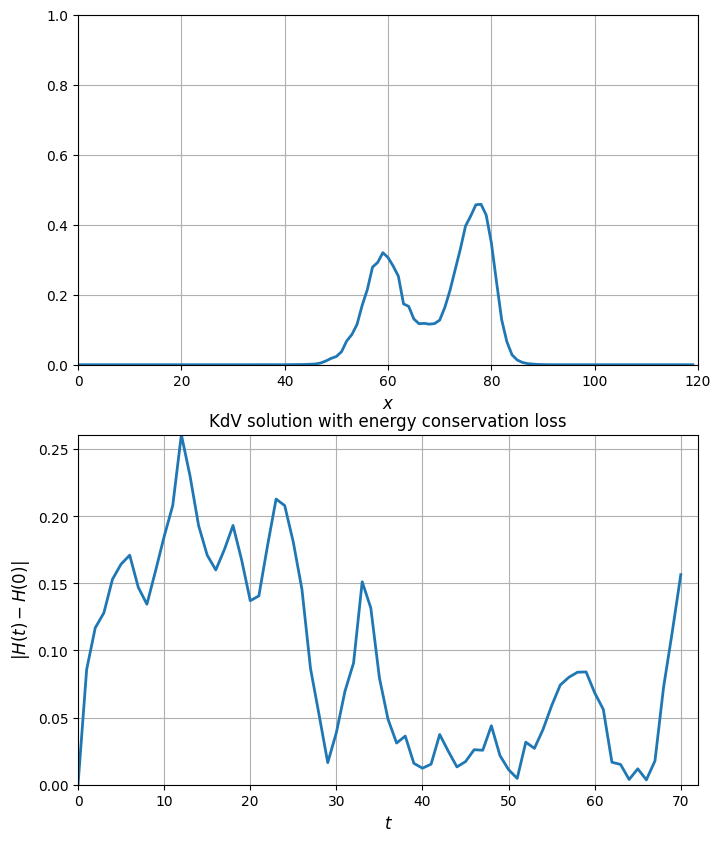

In [35]:
from metrics import energy_conservation, mass_conservation, momentum_conservation
def animate_single_w_energy(data, title, params, fps=10, energy_type="total"):
    rc('animation', html='jshtml')
    fig, ax = plt.subplots(2,1, figsize=(8, 10))
    plt.title(title)
    line1, = ax[0].plot([], [], lw=2)
    line2, = ax[1].plot([], [], lw=2)
    lines = [line1, line2]
    dx = params["P"] / params["spatial_len"]
    if energy_type == "momentum":
        H = momentum_conservation(data[None,:], dx)[0]
    elif energy_type == "mass":
        H = mass_conservation(data[None,:], dx)[0]
    else: # total energy
        H = energy_conservation(data[None,:], dx, params["eta"], params["gamma"])[0]

    for i in range(2):
        if i == 0:
            ax[i].set_ylim((0, 1))
            ax[i].set_xlabel('$x$', fontsize=12)
            ax[i].set_xlim((0, data.shape[-1]))
        else:
            ax[i].set_xlabel('$t$', fontsize=12)
            ax[i].set_ylabel('$|H(t) - H(0)|$', fontsize=12)
            ax[i].set_xlim((0, data.shape[0]))
            ax[i].set_ylim((0, H.max()))
        ax[i].grid()
    x = np.arange(data.shape[1])
    def init():
        lines[0].set_data([], [])
        lines[1].set_data([], [])
        return lines
    def animate(i):
        lines[0].set_data(x, data[i,:])
        lines[1].set_data(np.arange(i), H[:i] - H[0])
        return lines
    ani = animation.FuncAnimation(fig, animate, init_func=init,
                                  frames=data.shape[0], interval=20, blit=True)
    ani.save('plots/soliton_single.gif', fps=fps)

energy_type = "total"
ani = animate_single_w_energy(fake[single_example_nr], "KdV solution with energy conservation loss", params, fps=15, energy_type=energy_type)

In [ ]:
def animate_single(data, title):
    rc('animation', html='jshtml')
    fig, ax = plt.subplots()
    line, = ax.plot([], [], lw=2)
    ax.set_xlim((0, data.shape[1]))
    ax.set_ylim((0, 1))
    ax.set_xlabel('$x$', fontsize=12)
    ax.set_ylabel('$u$', fontsize=12)
    ax.grid()
    plt.title(title)
    x = np.arange(data.shape[1])
    def init():
        line.set_data([], [])
        return (line,)
    def animate(i):
        line.set_data(x, data[i,:])
        return (line,)
    ani = animation.FuncAnimation(fig, animate, init_func=init,
                                  frames=data.shape[0], interval=20, blit=True)
    ani.save('plots/twosolitons_synthetic.gif', fps=15)

ani = animate_single(fake[single_example_nr], "Synthetic solution of KdV system")